In [1]:
# !pip install netCDF4
# !pip install cartopy
# !pip install basemap 
# import sys
# print(sys.executable)
# print(sys.version)
# print(sys.version_info)

In [2]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate
import scipy
import tqdm
import matplotlib.colors as mcolors
# import pandas as pd


In [3]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')

# Initial data Analysis and Presentation
We will start by displaying the average precipitation in the Middle East region for the month of October, for each model and for CHIRPS2 (which is "Rainfall Estimates from Rain Gauge and Satellite Observations"). This should give as a good understanding of which models are performing well in this region and which ones are not.    
An important concern we ran into was the scale - each model uses a different scale, and so since we want to compare them all together (and specifically to the CHIRPS2 dataset), we need to interpolate the data to a common scale, which we chose to be the CHIRPS2 scale.    
Another important step - we needed to convert the precipitation units of the models from `kg m-2 s-1` to `mm/month`. To do so, we multiply the precipitation values by the number of seconds in a day (86400) and the number of days in a month (31). Along the way we multiply and divide by 1000 to convert the units from kg to g and then to mm, but it cancels out.    
One last detail is the boundaries of the map we want to plot. We will use 25N-40N and 25E-50E, in accordance with the article we are basing our analysis on.

In [4]:
unit_conversion = 86400 * 31
bounds_lat = [20, 40]
bounds_lon = [20, 50]
boundaries = bounds_lon + bounds_lat

In [5]:
def scale_chirps(target_dim: tuple, chirps_precip: np.ndarray) -> tuple:
    "This function scales the CHIRPS data to the target dimension, currently not in use"
    scale_factors = target_dim[0] / chirps_precip_data.shape[1], target_dim[1] / chirps_precip_data.shape[2]
    chirps_precip = scipy.ndimage.zoom(np.mean(chirps_precip_data, axis=0), scale_factors, order=1)  # order=1 for bilinear
    return chirps_precip

In [6]:
chirps_data = nc.Dataset(f"{CHIRPS_path}/chirps_octobers_middle_east_1981_2010.nc")
chirps_precip_data = chirps_data['precip'][:]
chirps_precip_mean = np.mean(chirps_precip_data, axis=0)

In [7]:
chirps_dim = chirps_data['precip'].shape[1], chirps_data['precip'].shape[2]

An issue we ran into here is how to choose the correct interpolation method. We are not sure if there are standards for weather related interpolation methods, and so we plan on looking into it.

In [8]:
def collect_all_datasets(precipitation_dir: str, target_dim: tuple, unit_conversion: float, bounds_lat: list, bounds_lon: list) -> dict:
    """
    Collects and processes all NetCDF files from the given directory.
    Interpolates each dataset to a predefined dimension and stores them in a 3D array.
    
    Args:
        precipitation_path (str): Path to the directory containing NetCDF files.
        target_dim (tuple): Dimensions of the target matrix.
        unit_conversion (float): Unit conversion factor.
        bounds_lat (list): Latitude bounds.
        bounds_lon (list): Longitude bounds.
    
    Returns:
        np.ndarray: 3D array of interpolated datasets.
    """
    interpolated_matrices = dict()

    for file in tqdm.tqdm(os.listdir(precipitation_dir)):
        filename = os.fsdecode(file)
        path = f"{precipitation_dir}/{filename}"
        data = nc.Dataset(path)
        print(f"{filename}")
#         print(data['lat'][:] if 'lat' in data.variables.keys() else data['latitude'][:])
#         print(data['lon'][:] if 'lon' in data.variables.keys() else data['longitude'][:])
        
        precipitation = data.variables['pr'][:]
        avg_pr_middle_east = np.mean(precipitation, axis=0)
        
        mm_avg_lat_lon = avg_pr_middle_east * unit_conversion
        
        original_matrix = mm_avg_lat_lon
        m, n = original_matrix.shape
        
        lat_grid = np.linspace(bounds_lat[0], bounds_lat[1], m)
        lon_grid = np.linspace(bounds_lon[0], bounds_lon[1], n)
        
        if m > target_dim[0] or n > target_dim[1]:
            # Downsample the matrix using bilinear interpolation
            scale_factors = target_dim[0] / m, target_dim[1] / n
            interpolated_matrix = scipy.ndimage.zoom(original_matrix, scale_factors, order=1)  # order=1 for bilinear

            
        else:
            # Upsample the matrix
            interpolator = interpolate.RegularGridInterpolator((lat_grid, lon_grid), original_matrix, method='slinear')

            new_lat_grid = np.linspace(bounds_lat[0], bounds_lat[1], target_dim[0])
            new_lon_grid = np.linspace(bounds_lon[0], bounds_lon[1], target_dim[1])

            new_grid_points = np.meshgrid(new_lat_grid, new_lon_grid, indexing='ij')

            new_points = np.stack([new_grid_points[0].ravel(), new_grid_points[1].ravel()], axis=-1)

            interpolated_matrix = interpolator(new_points).reshape(target_dim)
        
        interpolated_matrices[filename] = np.array(interpolated_matrix)

    return interpolated_matrices

In [9]:
def plot_precp_heatmap(ax, mat: np.ndarray, boundaries: list, label: str, title: str, treshold: float = 0.05) -> None:
    cmap = plt.get_cmap('jet')
    cmap_with_transparency = cmap(np.linspace(0, 1, cmap.N))
    
    #A treshold of 0.01 is the same as 1 mm
    cmap_with_transparency[:, -1] = np.where(np.linspace(0, 1, cmap.N) <= treshold, 0, 1)  # Last column is the alpha channel
    transparent_cmap = mcolors.ListedColormap(cmap_with_transparency)
       
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='whitesmoke')
    
    norm = mcolors.Normalize(vmin=np.min(mat), vmax=np.max(mat))
    im = ax.imshow(mat, origin='lower', cmap=transparent_cmap, extent=boundaries,
                    transform=ccrs.PlateCarree(), interpolation='none', norm=norm)

    cbar = plt.colorbar(im, ax=ax, label=label, orientation='horizontal', pad=0.05, fraction=0.046)
    cbar.set_label(label)
    ax.set_title(f"{title}")
#     plt.show()


In [10]:
interpolated_matrices = collect_all_datasets(precipitation_path, chirps_dim, unit_conversion, bounds_lat, bounds_lon)

  0%|                                                                                            | 0/24 [00:00<?, ?it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc


  4%|███▌                                                                                | 1/24 [00:00<00:16,  1.39it/s]

pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc


  8%|███████                                                                             | 2/24 [00:01<00:17,  1.22it/s]

pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc


 12%|██████████▌                                                                         | 3/24 [00:02<00:18,  1.14it/s]

pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc


 17%|██████████████                                                                      | 4/24 [00:03<00:16,  1.24it/s]

pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc


 21%|█████████████████▌                                                                  | 5/24 [00:03<00:13,  1.38it/s]

pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc


 25%|█████████████████████                                                               | 6/24 [00:04<00:10,  1.65it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc


 29%|████████████████████████▌                                                           | 7/24 [00:04<00:09,  1.81it/s]

pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc


 33%|████████████████████████████                                                        | 8/24 [00:05<00:08,  1.98it/s]

pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc


 38%|███████████████████████████████▌                                                    | 9/24 [00:05<00:06,  2.26it/s]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc


 42%|██████████████████████████████████▌                                                | 10/24 [00:05<00:05,  2.46it/s]

pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc


 46%|██████████████████████████████████████                                             | 11/24 [00:06<00:04,  2.60it/s]

pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc


 50%|█████████████████████████████████████████▌                                         | 12/24 [00:06<00:04,  2.58it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc


 54%|████████████████████████████████████████████▉                                      | 13/24 [00:06<00:03,  2.81it/s]

pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc


 58%|████████████████████████████████████████████████▍                                  | 14/24 [00:06<00:03,  3.07it/s]

pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc


 62%|███████████████████████████████████████████████████▉                               | 15/24 [00:07<00:02,  3.10it/s]

pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc


 67%|███████████████████████████████████████████████████████▎                           | 16/24 [00:07<00:02,  3.19it/s]

pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc


 71%|██████████████████████████████████████████████████████████▊                        | 17/24 [00:07<00:02,  3.23it/s]

pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc


 75%|██████████████████████████████████████████████████████████████▎                    | 18/24 [00:08<00:01,  3.32it/s]

pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc


 79%|█████████████████████████████████████████████████████████████████▋                 | 19/24 [00:08<00:01,  3.40it/s]

pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc


 88%|████████████████████████████████████████████████████████████████████████▋          | 21/24 [00:08<00:00,  3.81it/s]

pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc


 92%|████████████████████████████████████████████████████████████████████████████       | 22/24 [00:09<00:00,  3.75it/s]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:09<00:00,  3.76it/s]

pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.47it/s]


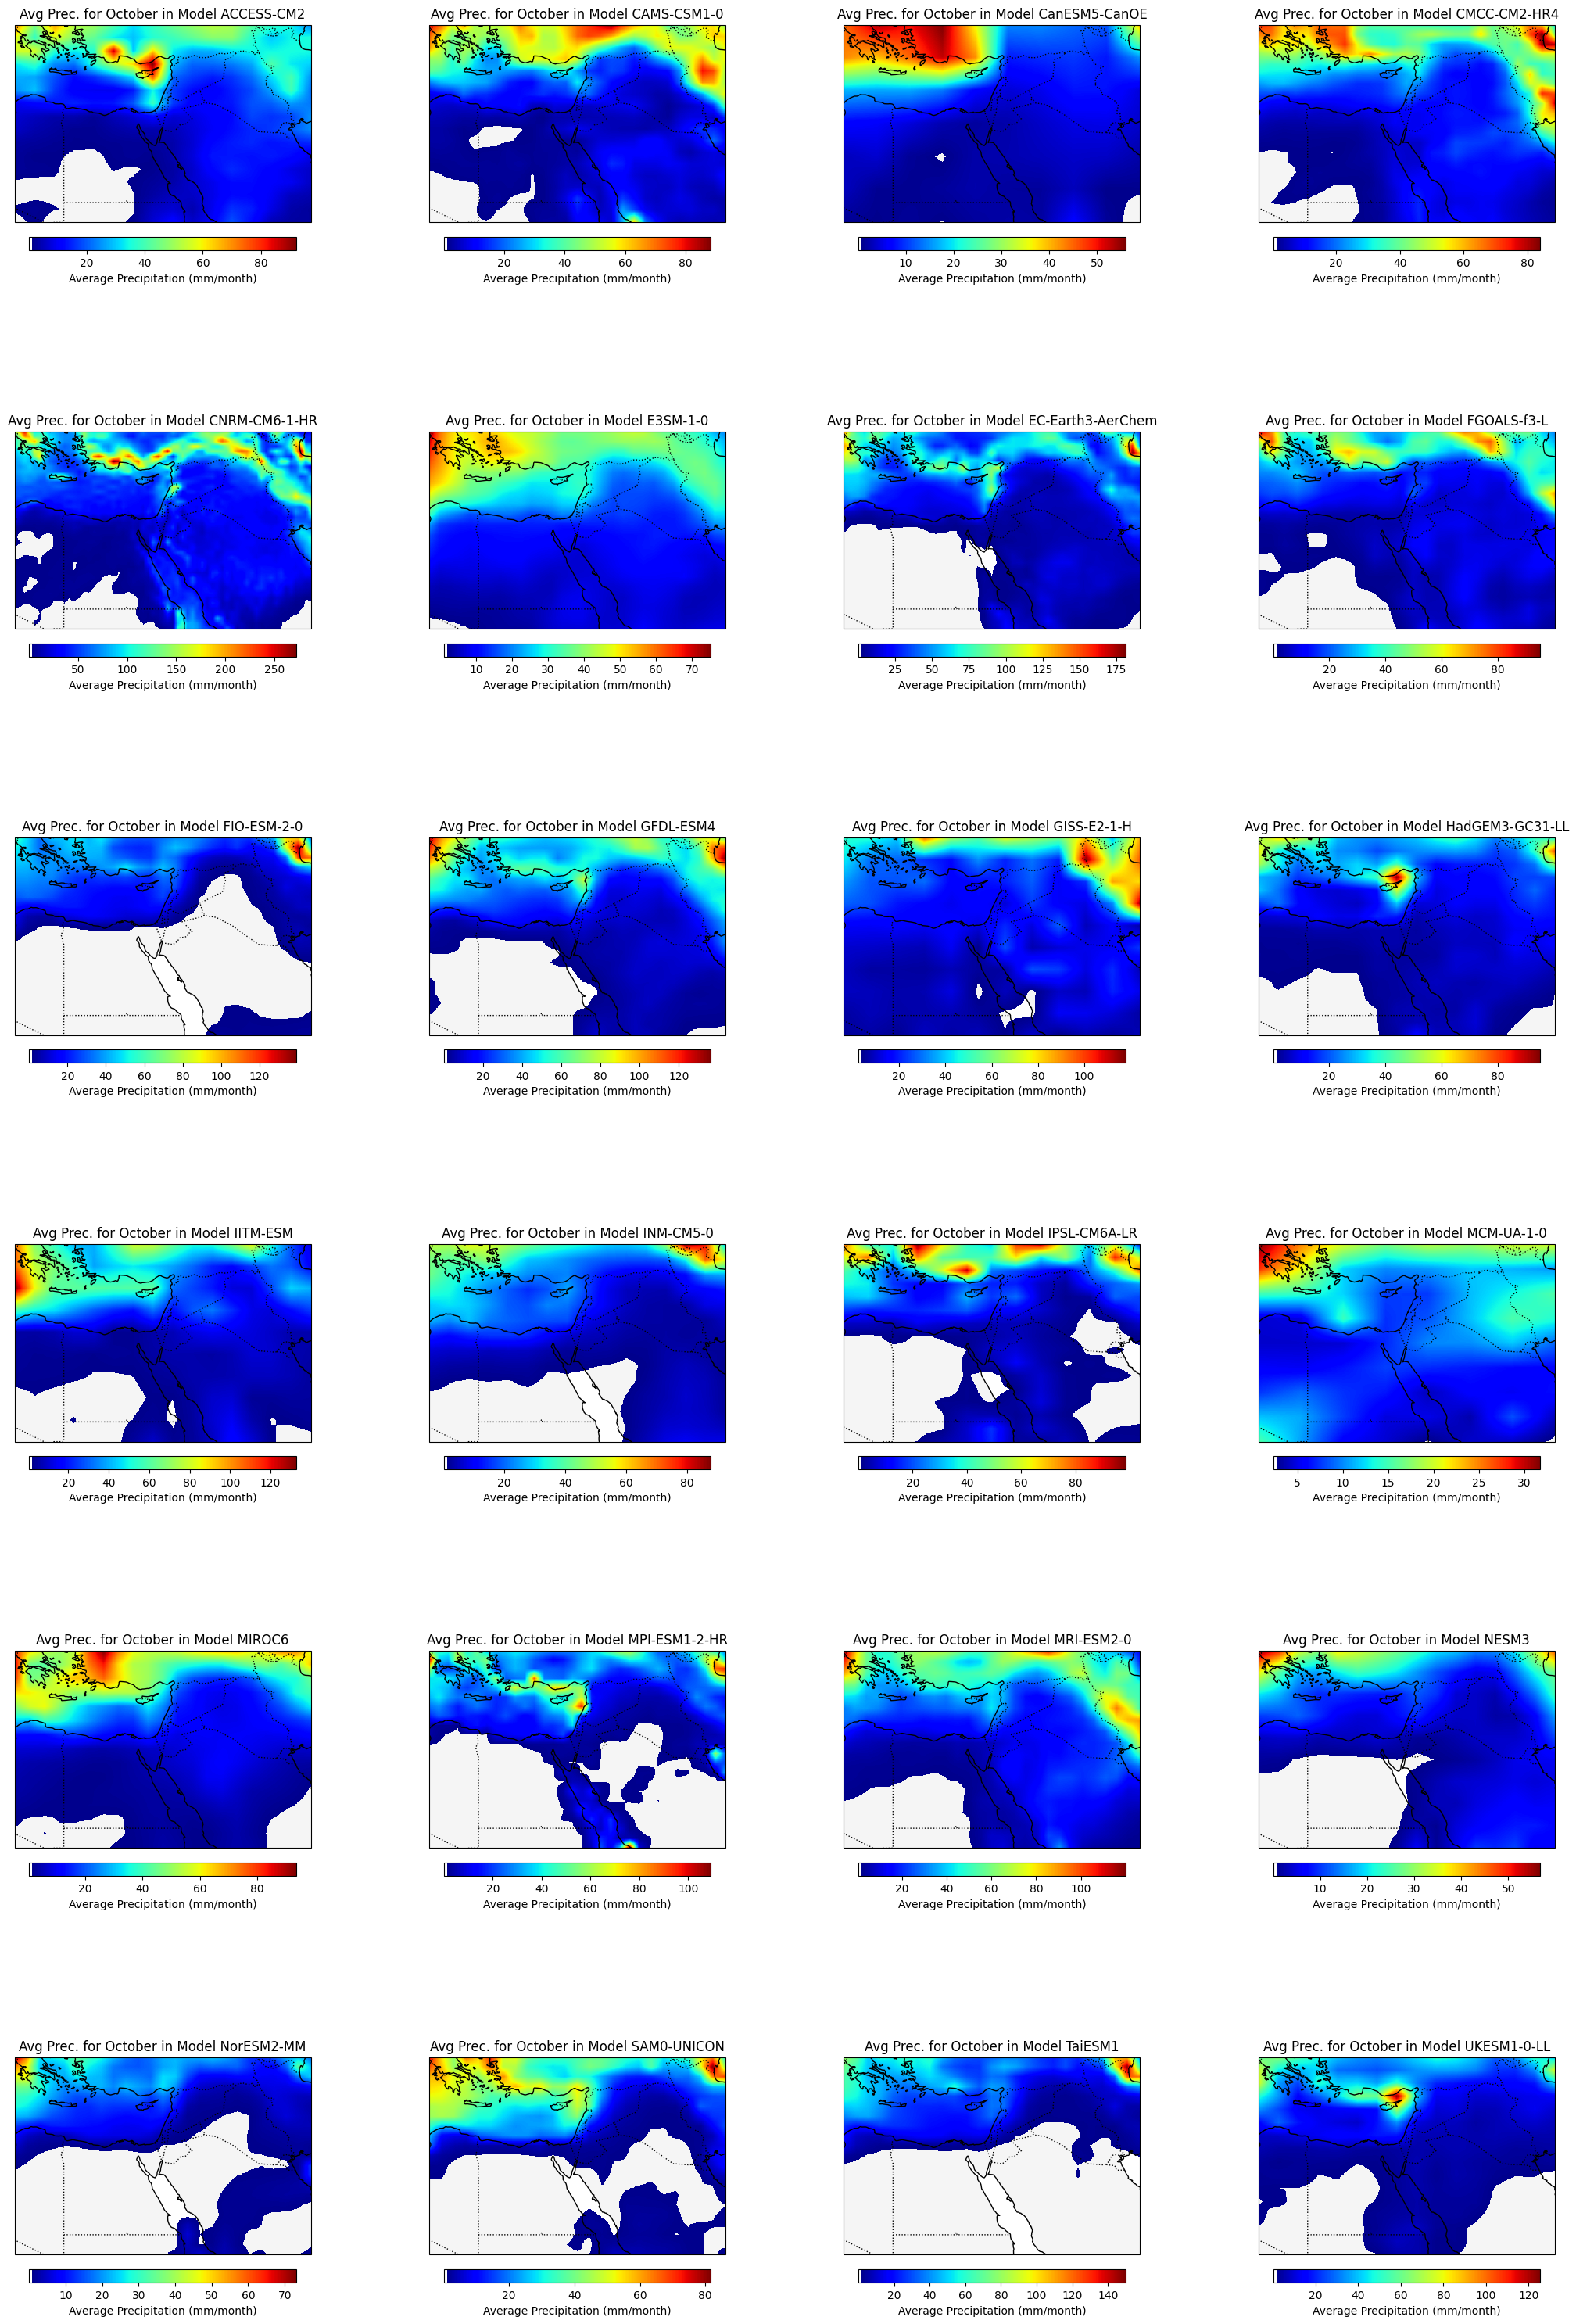

In [11]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(interpolated_matrices.values())
titles = list(interpolated_matrices.keys())


for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    plot_precp_heatmap(ax, value, boundaries, 'Average Precipitation (mm/month)', f'Avg Prec. for October in Model {key.split("_")[2]}', 0.01)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [12]:
interpolated_matrix_array_mean = np.mean(np.array([arr for arr in interpolated_matrices.values()]),axis=0)


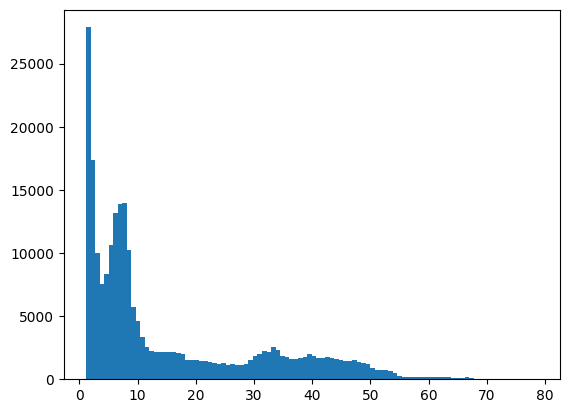

In [13]:
ax = plt.hist(interpolated_matrix_array_mean.ravel(),bins=100)
plt.show()

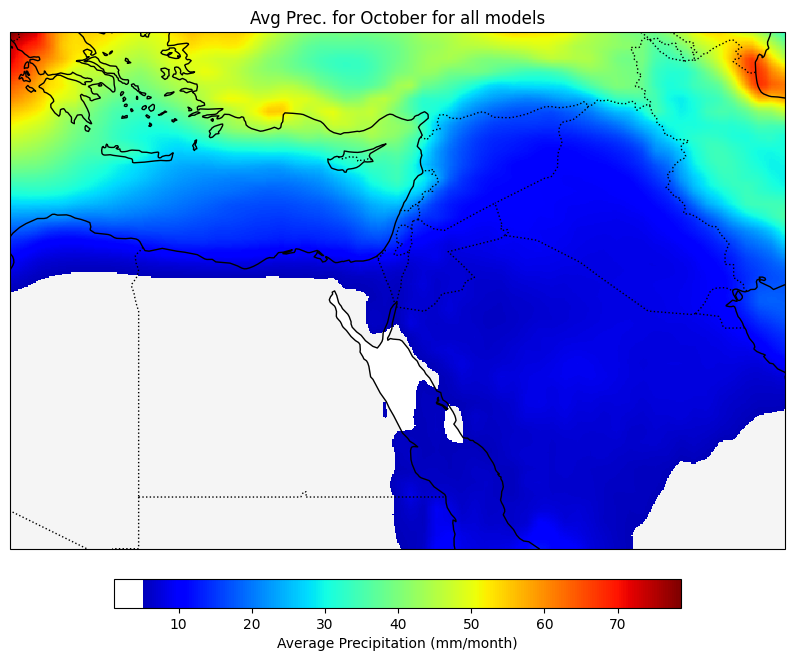

In [14]:
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

plot_precp_heatmap(ax2, interpolated_matrix_array_mean, boundaries, 'Average Precipitation (mm/month)', 'Avg Prec. for October for all models')

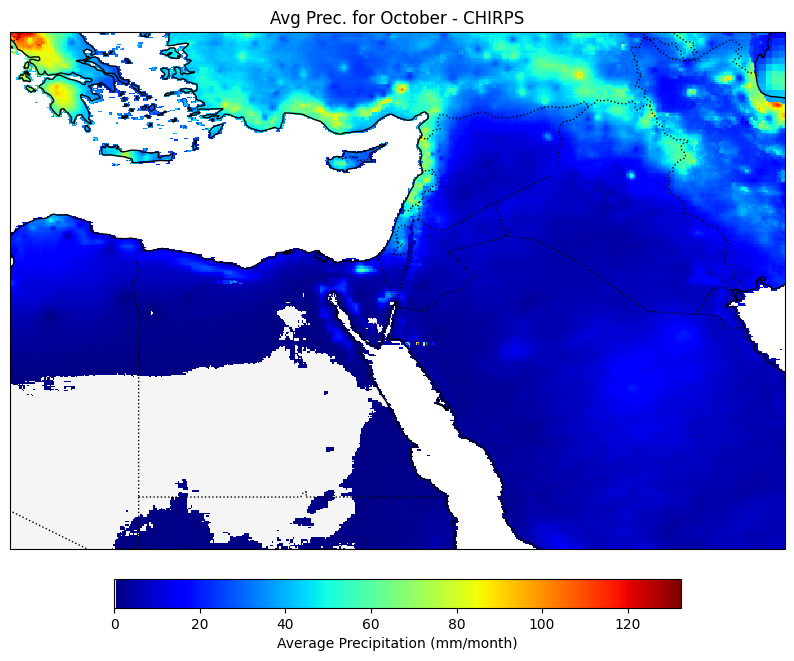

In [15]:
fig3, ax2 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_precp_heatmap(ax2, chirps_precip_mean, boundaries, 'Average Precipitation (mm/month)', 'Avg Prec. for October - CHIRPS', 0)

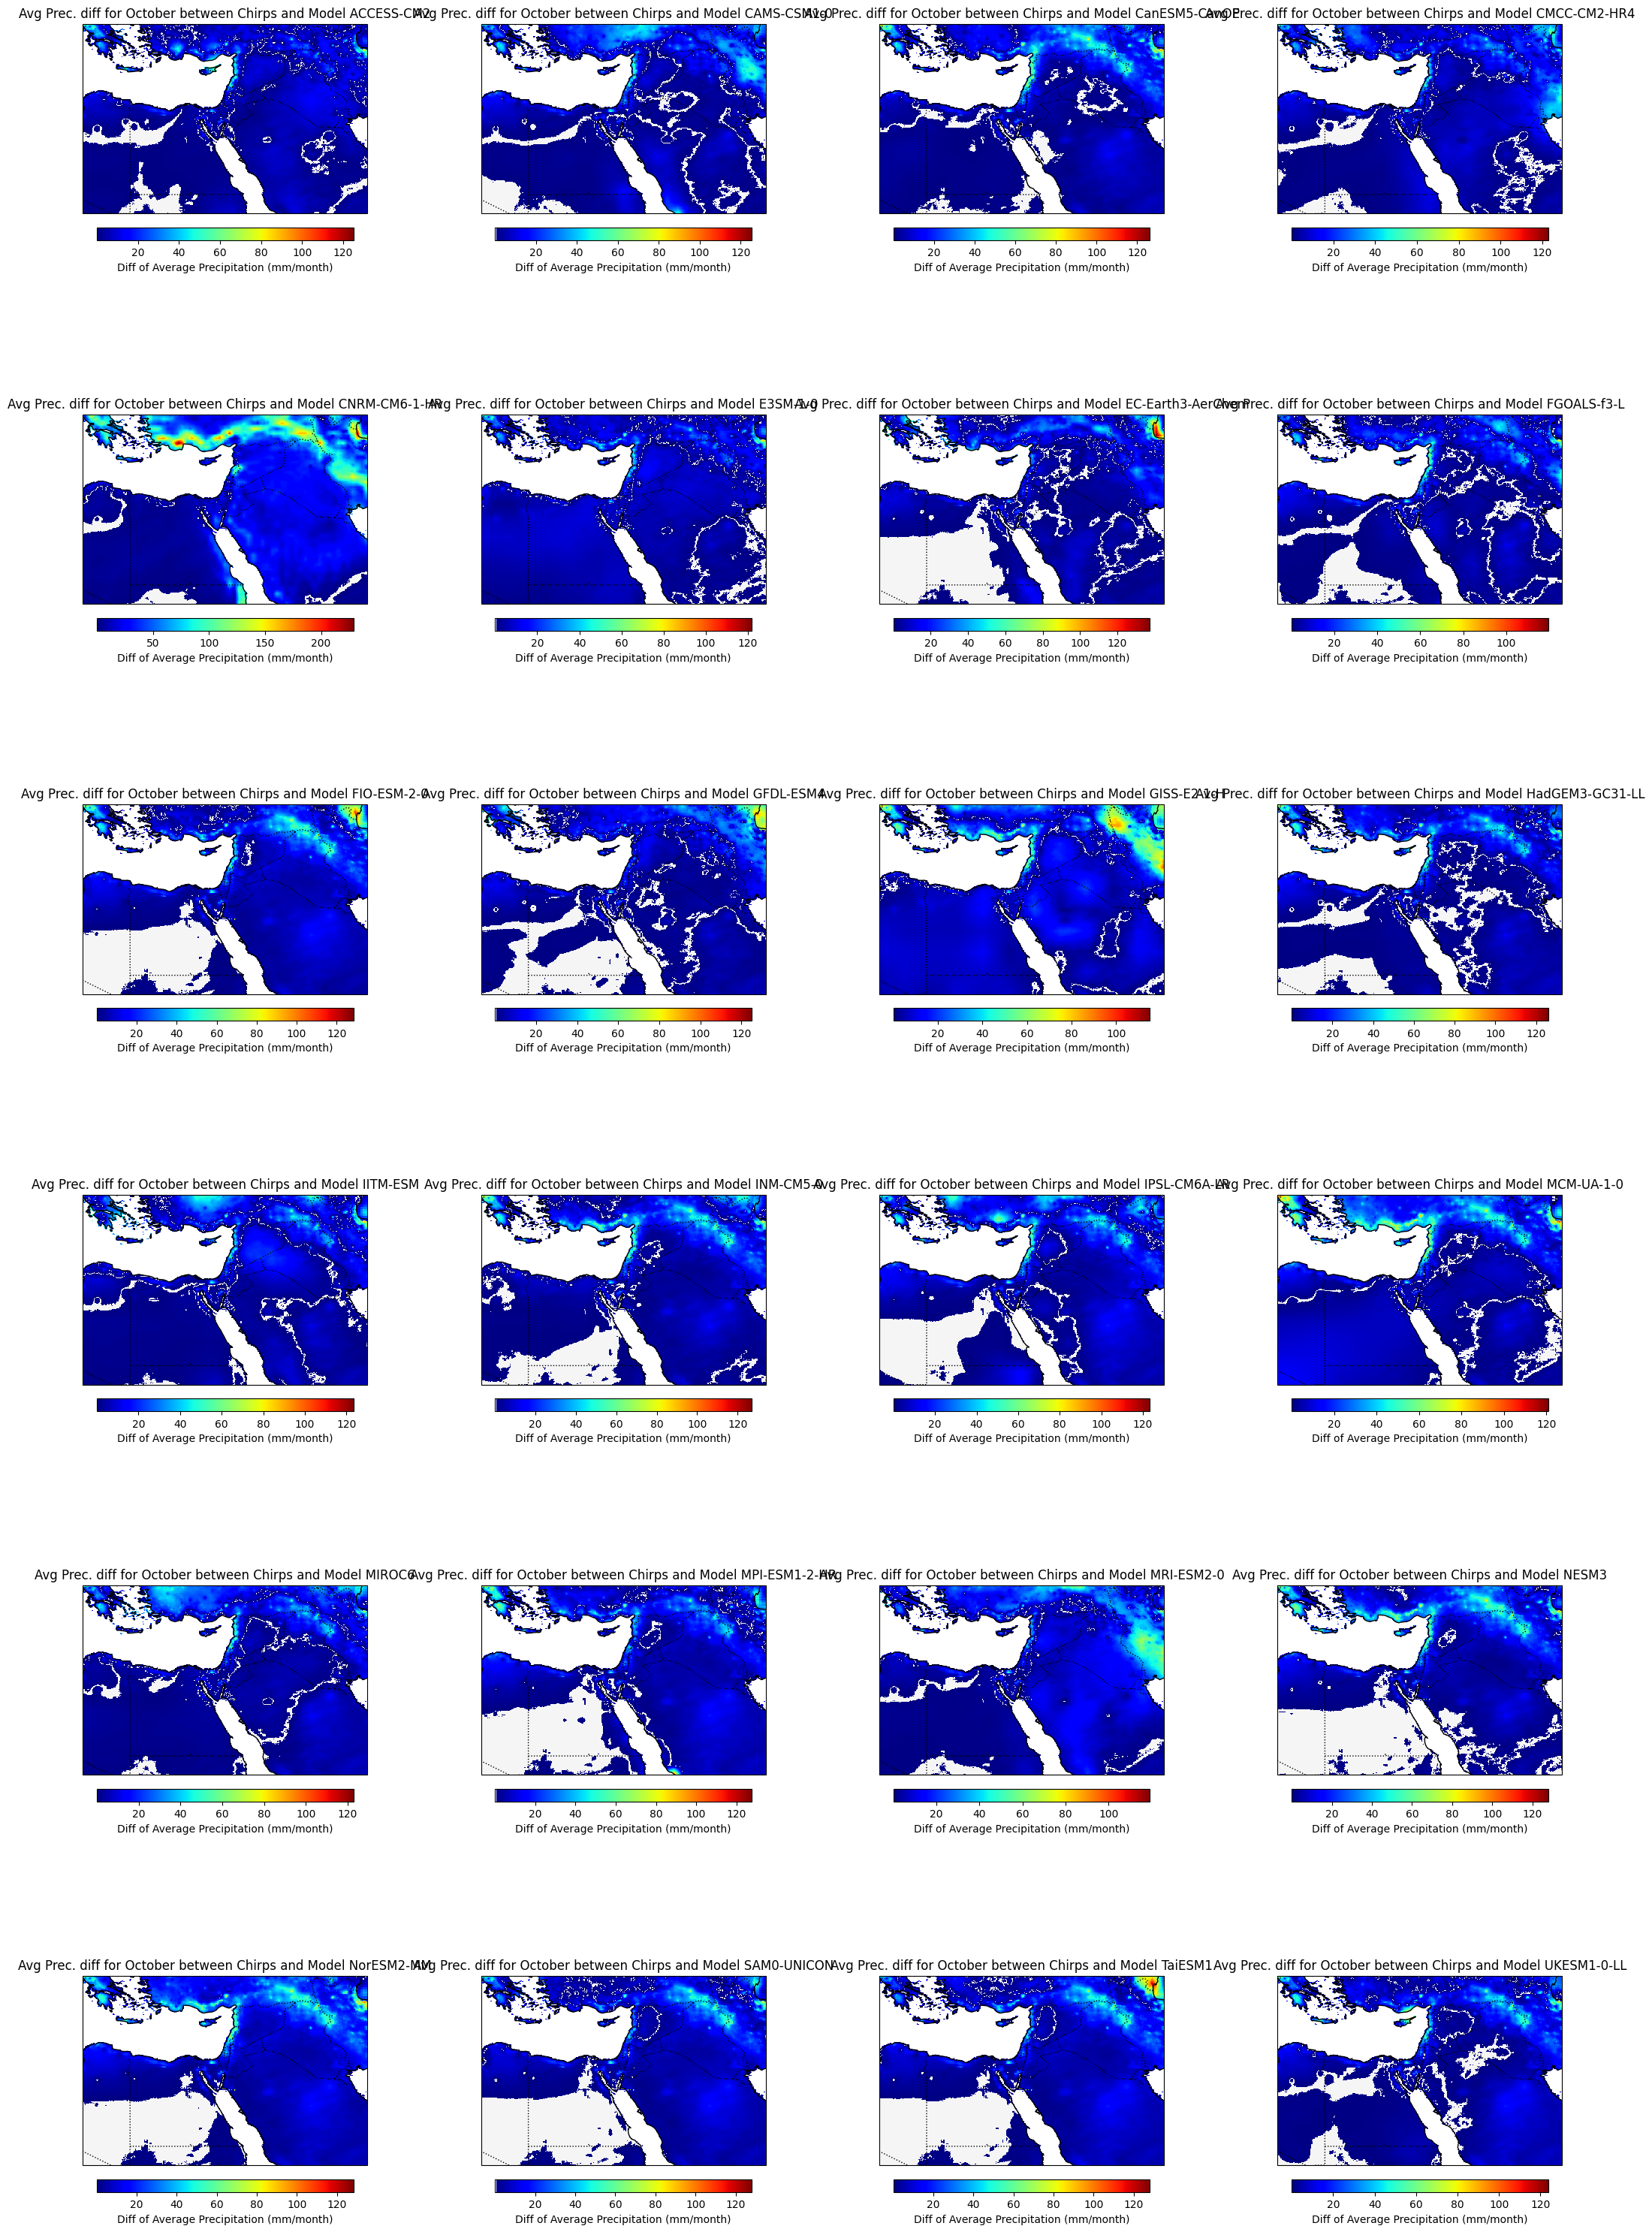

In [16]:
fig4, axes4 = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig4.tight_layout()
mats = [np.abs(chirps_precip_mean - arr) for arr in list(interpolated_matrices.values())]
titles = list(interpolated_matrices.keys())


for i, (ax, key, value) in enumerate(zip(axes4.ravel(), titles, mats)):
    plot_precp_heatmap(ax, value, boundaries, 'Diff of Average Precipitation (mm/month)', f'Avg Prec. diff for October between Chirps and Model {key.split("_")[2]}', 0)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

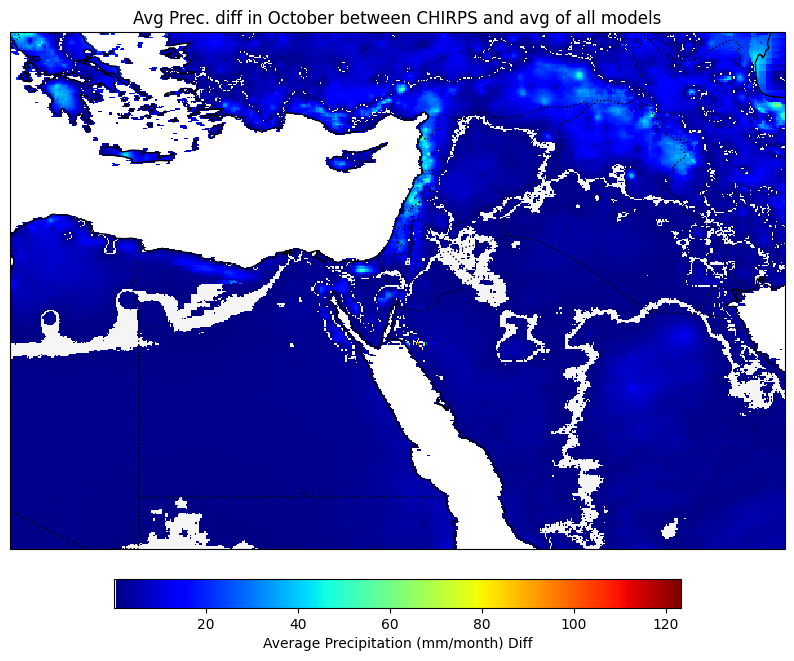

In [17]:
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

plot_precp_heatmap(ax5, np.abs(chirps_precip_mean - interpolated_matrix_array_mean), boundaries, 'Average Precipitation (mm/month) Diff', 'Avg Prec. diff in October between CHIRPS and avg of all models', 0)

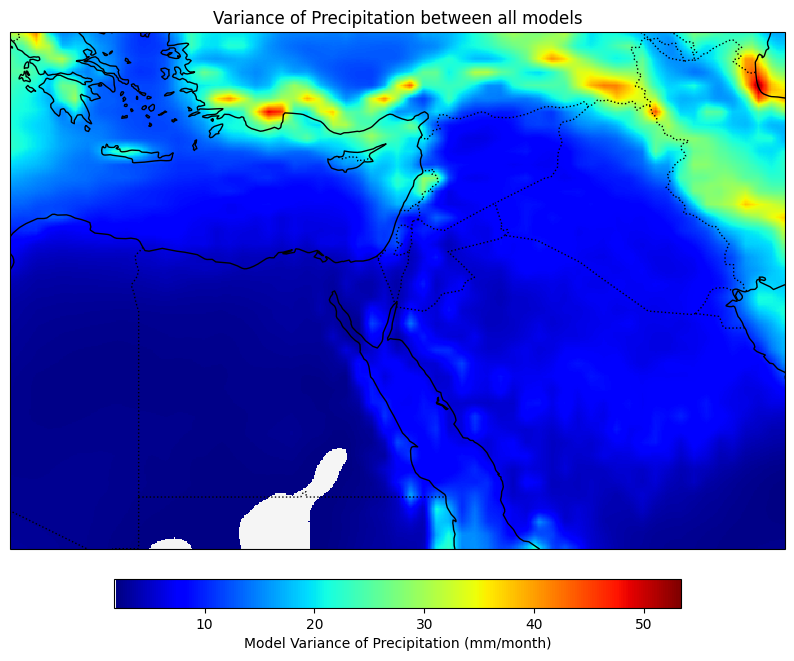

In [18]:
interpulated_matrix_array_std = np.std(np.array([arr for arr in interpolated_matrices.values()]),axis=0)
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_precp_heatmap(ax6, interpulated_matrix_array_std, boundaries, 'Model Stdev of Precipitation (mm/month)', 'Stdev of Precipitation between all models', 0)



# Paper Reproducing
In this part we will attempt to reproduce the correlation results from the original paper. This is done both to provide a sanity check, but also to create the general functions we will use later to calcuate the correlation on the data from the models

In [19]:
import pandas as pd

In [20]:
df_dmi = pd.read_csv(f"{data_relative_path}/PSL/DMI.csv")
df_wtio = pd.read_csv(f"{data_relative_path}/PSL/WTIO.csv")
df_seio = pd.read_csv(f"{data_relative_path}/PSL/SEIO.csv")

In [21]:
df_dmi.set_index('Year', inplace=True)
df_wtio.set_index('Year', inplace=True)
df_seio.set_index('Year', inplace=True)

In [22]:
df_dmi = df_dmi.query('Year >= 1981 and Year <= 2010')
df_wtio = df_wtio.query('Year >= 1981 and Year <= 2010')
df_seio = df_seio.query('Year >= 1981 and Year <= 2010')

In [23]:
dmi_oct = df_dmi['10']
wtio_oct = df_wtio['10']
seio_oct = df_seio['10']
obs_iod = pd.concat([dmi_oct, wtio_oct, seio_oct], axis=1, keys=['DMI', 'WTIO', 'SEIO'])

0.7453778857286607

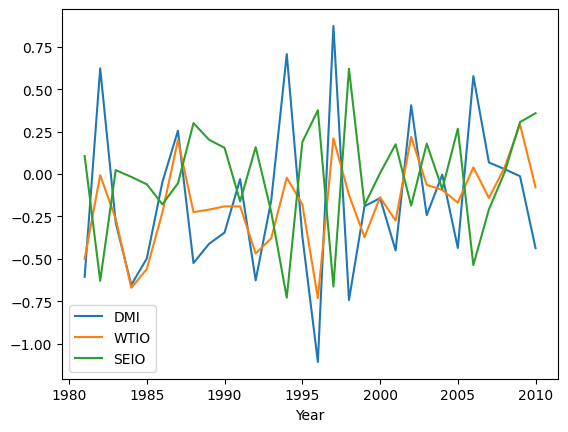

In [24]:
obs_iod.plot()
plt.legend(['DMI', 'WTIO', 'SEIO'])
obs_iod.corr()['DMI']['WTIO']

Next, we will plot the correlation between the DMI and the precipitation data.

In [25]:
def calc_dmi_precp_corr_loop(dmi: np.ndarray, precip: np.ndarray) -> np.ndarray:
    # Initialize an array to store the correlation coefficients for each grid point
    correlation_map = np.zeros((precip.shape[1], precip.shape[2]))

    # Compute the correlation for each grid point
    for i in range(precip.shape[1]):
        for j in range(precip.shape[2]):
            # Extract the time series for the current grid point
            precip_series = precip[:, i, j]

            # Compute the correlation coefficient between DMI and the current grid point's time series
            correlation_map[i, j] = np.corrcoef(dmi, precip_series)[0, 1]

    return correlation_map



def calc_dmi_precp_corr_vec(dmi: np.ndarray, precip: np.ndarray) -> np.ndarray:
    # Reshape precipitation data from (30, 600, 600) to (30, 360000)
    # Each column represents a grid point's time series

    # Step 1: Detrend the DMI to ensure no linear trend affects correlation
    dmi_detrended = dmi - np.mean(dmi)

    # Step 2: Detrend the precipitation data for each grid point
    precip_detrended = precip - np.mean(precip, axis=0)

    # Step 3: Normalize the detrended data
    dmi_normalized = dmi_detrended / np.std(dmi_detrended)

    # Step 4: Normalize the precipitation data along the time axis
    precip_normalized = precip_detrended / np.std(precip_detrended, axis=0)

    # Step 5: Compute the correlation coefficient across all grid points in one operation
    # Dot product between normalized DMI and normalized precipitation for each grid point
    correlation_map = np.tensordot(dmi_normalized, precip_normalized, axes=1) / (len(dmi) - 1)

#     precipitation_flat = precip.reshape(precip.shape[0], -1)

#     # Mean-center the DMI and precipitation data
#     dmi_centered = dmi - np.mean(dmi)
#     precipitation_centered = precipitation_flat - np.mean(precipitation_flat, axis=0)

#     # Calculate the standard deviation of DMI and precipitation data
#     dmi_std = np.std(dmi)
#     precipitation_std = np.std(precipitation_flat, axis=0)

#     # Compute the normalized (z-score) DMI and precipitation data
#     dmi_normalized = dmi_centered / dmi_std
#     precipitation_normalized = precipitation_centered / precipitation_std

#     # Compute the correlation coefficients using matrix multiplication
#     correlation_flat = np.dot(dmi_normalized, precipitation_normalized) / (len(dmi) - 1)

#     # Reshape the correlation coefficients back 
#     correlation_map = correlation_flat.reshape(precip.shape[1], precip.shape[2])

    return correlation_map


In [34]:
def calc_corr_t_test(r: float, n: int = 30):
    return r * np.sqrt((n-2) / (1-r**2))
    
alpha = 0.05

In [41]:
corr_map = calc_dmi_precp_corr_loop(dmi_oct.values, chirps_precip_data)

# corr_map = calc_dmi_precp_corr_vec(dmi_oct.values, chirps_precip_data)

/root/.pyenv/versions/3.10.11/envs/dsproj/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/.pyenv/versions/3.10.11/envs/dsproj/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [43]:
corr_map_tested = np.where(calc_corr_t_test(corr_map) < alpha, 0, corr_map)

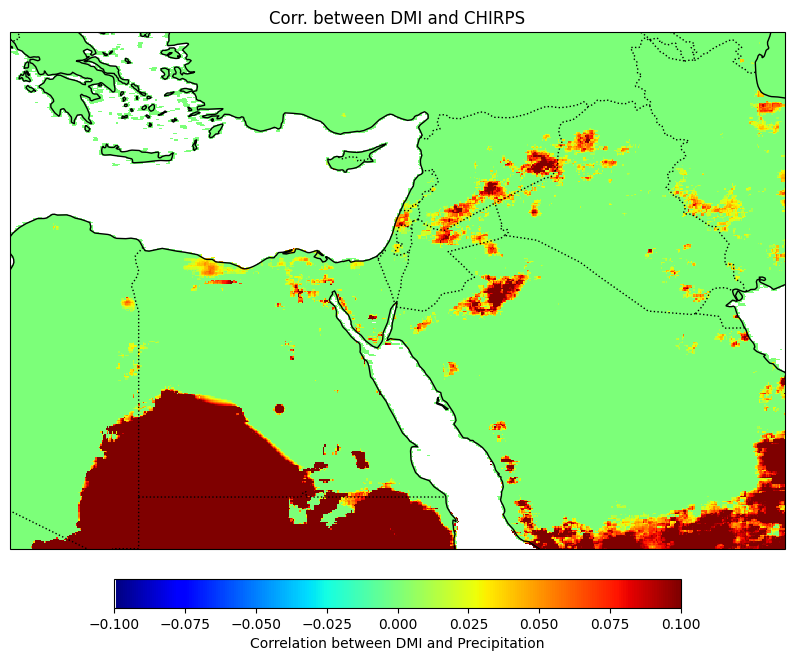

In [44]:
fig7, ax7 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_precp_heatmap(ax7, corr_map_tested, boundaries, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS', 0)

In [38]:
corr_map_tested

array([[0.        , 0.        , 0.        , ..., 0.12357669, 0.13890073,
        0.14392548],
       [0.        , 0.        , 0.        , ..., 0.12233107, 0.13535496,
        0.14482186],
       [0.        , 0.        , 0.        , ..., 0.14037886, 0.15096689,
        0.16402671],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
calc_corr_t_test(corr_map)

/tmp/ipykernel_1408/2652315711.py:2: RuntimeWarning: invalid value encountered in sqrt
  return r * np.sqrt((n-2) / (1-r**2))


array([[-1.63950381, -1.59914165, -1.12055143, ...,  0.65895728,
         0.74218811,  0.76959469],
       [-1.654265  , -1.65230155, -1.11533891, ...,  0.6522137 ,
         0.72288372,  0.77449012],
       [-1.68055405, -1.66997177, -1.17240903, ...,  0.75024415,
         0.80810351,  0.87986476],
       ...,
       [-2.09795894, -2.23165403, -2.16089978, ..., -1.12394894,
        -1.15499269, -1.03238737],
       [-2.16881002, -2.17922827, -2.12751428, ..., -0.99515996,
        -0.9345652 , -0.99127261],
       [-2.20067946, -2.16974243, -2.20335392, ..., -0.9925309 ,
        -0.87961092, -0.94151589]])